In [88]:
## To get top actors and directors and production houses.

from BeautifulSoup import BeautifulSoup
from selenium import webdriver
import pandas as pd
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
import sys
import time
import os
import logging
import argparse
import requests
import codecs
import json
import re

namel = []
actingl = []
overalll = []
rolel = []
namedir = []

user_agent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.76 Safari/537.36"

def get_actors():
    
    url = "http://www.imdb.com/list/ls050274118/?start=1&view=detail&sort=starmeter:asc"
    headers = { 'User-Agent' : user_agent }
    response = requests.get(url, headers=headers)
    html = response.text.encode('utf-8')
    soup = BeautifulSoup(html)
    actors = soup.findAll("div", {"class": "info"})
    descriptions = soup.findAll("div", {"class": "description"})[1:]


    for actor in actors: 
        try:
            name = actor.find('a', href = True).find(text = True)
            namel.append(name)
        except Exception, e:
            print "Not found"

    for desc in descriptions:
            raw = desc.contents
            data = [x for x in raw if not hasattr(x,"name") or not x.name == "br"]  
            Overall_Versatility = data[3].split(" ")[3]
            overalll.append(Overall_Versatility)
            Role_Transformation = data[4].split(" ")[3]
            rolel.append(Role_Transformation)
            try:   
                Acting_Skill = data[2].split(" ")[3]
                actingl.append(Acting_Skill)
            except Exception, e:
                actingl.append("4.5")

    data = {"Name" : namel , "Acting_Skill" : actingl, "Overall_Versatility" : overalll, "Role_Transformation" : rolel}
    df = pd.DataFrame.from_records(data, columns= ['Name','Acting_Skill','Overall_Versatility','Role_Transformation'])

    with open ('actor_data.csv','w') as f:
        df.to_csv(f)
    
def get_directors():
    
    url = "http://www.imdb.com/list/ls000075300/?start=1&view=detail&sort=starmeter:asc"
    headers = { 'User-Agent' : user_agent }
    response = requests.get(url, headers=headers)
    html = response.text.encode('utf-8')
    soup = BeautifulSoup(html)
    directors = soup.findAll("div", {"class": "info"})

    for director in directors: 
        try:
            name = director.find('a', href = True).find(text = True)
            namedir.append(name)
        except Exception, e:
            print "Not found"


    datad = {"Name" : namedir }
    dfdir = pd.DataFrame.from_records(datad)

    with open ('director_data.csv','w') as f:
        dfdir.to_csv(f)
        
if __name__ == "__main__":
    
    
    get_actors()
    get_directors()
    
    
    
    

In [ ]:
## Scraper for IMDB to get top 500 movies according to their revenue for 2000-2016


import os
import sys
import time
import logging
import requests
from BeautifulSoup import BeautifulSoup
import re

start_year = 2000
end_year = 2017
first_stage_complete = False
second_stage_complete = False
datadir = 'data/'
base_url = "http://www.imdb.com/"
user_agent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.76 Safari/537.36"
regex = re.compile('[^A-Za-z0-9\s]')
money_re = re.compile('[^0-9]')


def get_year_page(year,index):
    url = base_url + 'search/title?sort=boxoffice_gross_us&start=' + str(index) + '&title_type=feature&year=' + str(year) + ',' + str(year)
    time.sleep(1)
    headers = {'User-Agent': user_agent}
    response = requests.get(url, headers=headers)
    html = response.text.encode('utf-8')
    return html

def parse_year_page(html):
    movie_urls = []
    last_index = 1
    soup = BeautifulSoup(html)
    table = soup.find('table', {'class':'results'})

    movies = table.findAll('tr', {'class':'even detailed'}) + table.findAll('tr', {'class':'odd detailed'})
    for m in movies:
        index = m.find('td', {'class':'number'}).find(text=True).strip('.')
        last_index = index
        title = m.find('td', {'class':'title'})
        link = title.find('a', href=True)['href']
        movie_urls.append(link)
    return movie_urls, last_index

def get_business_page(movie_id):
    url = base_url + 'title/' + movie_id + '/business'
    headers = {'User-Agent': user_agent}
    time.sleep(.5)
    response = requests.get(url, headers=headers, timeout = 10)
    html = response.text.encode('utf-8')
    return html


def parse_business_page(movie_id):
    html = get_business_page(movie_id)
    soup = BeautifulSoup(html)
    content = soup.find('div', {'id':'tn15content'}).findAll(text=True)
    cleaned_content = []
    for i in content:
        if len(i) > 5 and len(i) < 100:
            cleaned_content.append(i.strip())
    if cleaned_content[0].lower() != 'budget':
        budget = 0
    else:
        raw_budget = cleaned_content[1].replace('&#163;','')
        budget = float(money_re.sub('', raw_budget))
    gross_found = False
    weekend_gross_found = False
    max_gross = 0
    for i in cleaned_content:
        if not gross_found:
            if i.lower() == 'opening weekend':
                gross_found = True
        elif not weekend_gross_found:
            if i.lower() == 'weekend_gross_found':
                weekend_gross_found = True
            else:
                if '&#163;' in i or '$' in i:
                    cleaned_i = i.replace('&#163;','')
                    idx = len(cleaned_i)
                    try:
                        idx = cleaned_i.index(' ')
                    except:
                        pass
                    cleaned_i = cleaned_i[:idx]
                    try:
                        new_gross = float(money_re.sub('', cleaned_i))
                    except ValueError:
                        new_gross = 0
                    if new_gross > max_gross:
                        max_gross = new_gross
        else:
            pass
    if gross_found and budget == 0:
        try:
            opening =  cleaned_content[1].replace('&#163;','')
            opening = float(money_re.sub('', opening))
            return budget, max_gross, opening
        except Exception, e:
            return budget, max_gross, 0
    elif gross_found and budget != 0:
        try:
            opening =  cleaned_content[3].replace('&#163;','')
            opening = float(money_re.sub('', opening))
            return budget, max_gross, opening
        except Exception, e:
            return budget, max_gross, 0
    else:
        return budget, max_gross, 0

def get_cast_page(movie_id):
    url = base_url + 'title/' + movie_id + '/fullcredits'
    headers = {'User-Agent': user_agent}
    time.sleep(1)
    response = requests.get(url, headers=headers , timeout=10)
    html = response.text.encode('utf-8')
    return html

def parse_cast_page(movie_id):
    html = get_cast_page(movie_id)
    cast_list = []
    soup = BeautifulSoup(html)
    info = soup.find('div', {'id':'fullcredits_content'})
    actors = info.find('table', {'class':'cast_list'})
    if actors == None:
        return []
    odd_actors = actors.findAll('tr', {'class': 'odd'})
    even_actors = actors.findAll('tr', {'class': 'even'})
    if odd_actors == None and even_actors:
        return []
    elif odd_actors == None:
        count = 0
        for t in even_actors:
            if count > 5:
                break
            name = regex.sub('', t.find('td', {'itemprop':'actor'}).find('span', {'itemprop':'name'}).find(text=True))
            cast_list.append(name)
    elif even_actors == None:
        count = 0
        for t in odd_actors:
            if count > 5:
                break
            name = regex.sub('', t.find('td', {'itemprop':'actor'}).find('span', {'itemprop':'name'}).find(text=True))
            cast_list.append(name)
    else:
        count = 0
        for t in odd_actors:
            if count > 3:
                break
            name = regex.sub('', t.find('td', {'itemprop':'actor'}).find('span', {'itemprop':'name'}).find(text=True))
            cast_list.append(name)
            count += 1
        count = 0
        for t in even_actors:
            if count > 3:
                break
            count += 1
            name = regex.sub('', t.find('td', {'itemprop':'actor'}).find('span', {'itemprop':'name'}).find(text=True))
            cast_list.append(name)
    return cast_list


def get_production(movie_id):
    url = base_url + 'title/' + movie_id + '/companycredits'
    headers = {'User-Agent': user_agent}
    time.sleep(.5)
    response = requests.get(url, headers=headers, timeout=10)
    html = response.text.encode('utf-8')

    soup = BeautifulSoup(html)
    content = soup.find('div', {'id':'company_credits_content'})
    if content != None:
        production = content.find('ul', {'class':'simpleList'})
        if production != None:
            production = production.find('a',{'href': True})
        if production != None:
            production = production.find(text=True)
            return production
        else:
            return None
    else:
        return None

def get_movie_page(movie_id):
    url = base_url + 'title/' + movie_id + '/'
    headers = {'User-Agent': user_agent}
    time.sleep(1)
    response = requests.get(url, headers=headers , timeout=10)
    html = response.text.encode('utf-8')
    return html

def parse_movie_page(link):
    director = []
    date = 0
    rating = 0
    total_rating = 0
    movie_id = link.replace('/title/', '').replace('/', '').strip()
    html = get_movie_page(movie_id)
    soup = BeautifulSoup(html)
    overview = soup.find('div', {'id':'title-overview-widget'})
    if overview != None:
        title_area = overview.find('div', {'class':'title_wrapper'})
        title = title_area.find('h1', {'itemprop':'name'}).find(text=True).replace('&nbsp;','')
        title = regex.sub('',title)
        year = regex.sub('',title_area.find('span', {'id':'titleYear'}).find('a', href=True).find(text=True))
        rating_area = overview.find('div', {'class':'imdbRating'})
        if rating_area != None:
            rating = rating_area.find('div', {'class':'ratingValue'})
        if rating != None:
            rating = rating.find('span', {'itemprop':'ratingValue'}).find(text=True)
            total_rating = rating_area.find('span', {'class':'small'}).find(text = True).replace(',','')
        date_area = title_area.find('meta',{'itemprop' : 'datePublished'})
        if date_area != None:
            date = date_area['content']
        director_area = overview.findAll('span',{'itemprop':'director'})
        if director_area !=None:
            for direc in director_area:
                director.append(direc.find('span',{'itemprop':'name'}).find(text=True))
            director = [str(d) for d in director]
        budget, revenue, opening = parse_business_page(movie_id)
        cast = parse_cast_page(movie_id)
        cast = [str(c) for c in cast]

        production = get_production(movie_id)
        movie = (movie_id, title, year, date, rating, total_rating, budget, revenue, opening, production, director, cast)
        return movie
    else:
        return None

if __name__ == "__main__":
    current_dir = os.getcwd()
    if not os.path.exists(os.path.join(current_dir, datadir)):
        os.makedirs(os.path.join(current_dir, datadir))
    movie_urls = []
    movie_info = []
    cc= 0
    
    for year in range (start_year,end_year):
        print year
        last_index = 1
        while last_index < 500:
            html = get_year_page(year, last_index)
            (m, i) = parse_year_page(html)
            movie_urls += m
            last_index = int(i) + 1
            time.sleep(1)

    with open(os.path.join(datadir, 'link_list2016_2.csv'), "w") as h:
        for u in movie_urls:
            h.write(u+'\n')
    
    if first_stage_complete:

        with open(os.path.join(datadir, 'link_list2016_2.csv'), "r") as h:
            for u in h:
                movie_urls.append(u)

    with open(os.path.join(datadir, 'movie_info3_2.csv'), "w") as h:
        count = 0
        for u in movie_urls:
            try:
                count += 1
                print count
                next_movie = parse_movie_page(u)
                time.sleep(1)
                for i in range(0,len(next_movie)):
                    h.write(str(next_movie[i]) + ',')
                h.write('\n')
            except:
                pass


In [3]:
## cleaning data 
import pandas as pd
import os
datadir = 'data/'
movie_info = []
with open(os.path.join(datadir, 'movie_info3_2.csv'), "r") as h:
    for u in h:
        next_movie = []
        director_list = []
        
        movie_stuff = u.split(',')
        for i in range(0,len(movie_stuff)):
            if i < 10:
                next_movie.append(movie_stuff[i])
            else:
                name = movie_stuff[i].replace('[','').replace(']','')
                director_list.append(name)
        next_movie.append(director_list)
        if float(next_movie[6]) != 0 and float(next_movie[7]) > 0  :
            movie_info.append(next_movie)
        
print len(movie_info)
dfmovie = pd.DataFrame(movie_info, columns = ['imdbid','name','year','date','rating','outof','budget','revenue','first_week','production','director'])
dfmovie

3615


,imdbid,name,year,date,rating,outof,budget,revenue,first_week,production,director
0,tt0170016,How the Grinch Stole Christmas,2000,11/17/00,6,139172,123000000,345141403,55082330,Universal Pictures,"['Ron Howard', , \r\n]"
1,tt0207201,What Women Want,2000,12/15/00,6.4,156277,70000000,374111707,33614543,Paramount Pictures,"['Nancy Meyers', , \r\n]"
2,tt0212338,Meet the Parents,2000,10/6/00,7,256121,55000000,330444045,28623300,Universal Pictures,"['Jay Roach', , \r\n]"
3,tt0175142,Scary Movie,2000,7/7/00,6.2,183807,19000000,278019771,42346669,Dimension Films,"['Keenen Ivory Wayans', , \r\n]"
4,tt0130623,Dinosaur,2000,5/19/00,6.4,37520,127500000,354248063,38854851,Walt Disney Pictures,"['Eric Leighton', 'Ralph Zondag', \r\n]"
5,tt0195685,Erin Brockovich,2000,3/17/00,7.3,132320,52000000,256271286,28138465,Universal Pictures,"['Steven Soderbergh', , \r\n]"
6,tt0181865,Traffic,2000,1/5/01,7.6,168551,48000000,207515725,184725,Bedford Falls Company,"[ The, 'Steven Soderbergh', \r\n]"
7,tt0208003,Big Mommas House,2000,6/2/00,5.1,65558,30000000,173959438,25661041,Twentieth Century Fox Film Corporation,"['Raja Gosnell', , \r\n]"
8,tt0187393,The Patriot,2000,6/28/00,7.1,203970,110000000,215294342,22413710,Columbia Pictures Corporation,"['Roland Emmerich', , \r\n]"
9,tt0120630,Chicken Run,2000,6/23/00,7,137419,42000000,224834564,17506162,DreamWorks Animation,"['Peter Lord', 'Nick Park', \r\n]"


In [4]:
## making the top directors list
import csv
with open('./data/500_directors.csv') as movief:
    reader = csv.reader(movief)
    directorlist = list(reader)
df = pd.DataFrame(directorlist)
df[0] = df[0].apply(lambda x: x.lower())
dflist = df[0].tolist()
dflist 

['woody allen',
 'pedro almod\xcc_var',
 'robert altman',
 'paul thomas anderson',
 'kenneth anger',
 'michelangelo antonioni',
 'matthew barney',
 'ingmar bergman',
 'luis bu\xcc\xb1uel',
 'tim burton',
 'laurent cantet',
 'nuri bilge ceylan',
 'claude chabrol',
 'charles chaplin',
 'henri-georges clouzot',
 'joel coen',
 'francis ford coppola',
 'alex cox',
 'david cronenberg',
 'jules dassin',
 'terence davies',
 'maya deren',
 'carl theodor dreyer',
 'sergei m. eisenstein',
 'abel ferrara',
 'david fincher',
 'john ford',
 'georges franju',
 'samuel fuller',
 'abel gance',
 'bahman ghobadi',
 'terry gilliam',
 'jean-luc godard',
 'peter greenaway',
 'd.w. griffith',
 'michael haneke',
 'hal hartley',
 'howard hawks',
 'todd haynes',
 'werner herzog',
 'alfred hitchcock',
 'hsiao-hsien hou',
 'john huston',
 'derek jarman',
 'jim jarmusch',
 'buster keaton',
 'krzysztof kieslowski',
 'takeshi kitano',
 'stanley kubrick',
 'lev kuleshov',
 'akira kurosawa',
 'fritz lang',
 'chang-don

In [30]:
## giving director rating as 1 if the director in the top list
lis = []
for u in dfmovie['director']:
    if u[0].lower().replace('\'','') in dflist or u[1].lower().replace('\'','') in dflist:
        lis.append(1)
    else:
        lis.append(0)
dfmovie['dir_rate'] = lis

In [6]:
print len(dfmovie[dfmovie['dir_rate'] == 1])

581


In [7]:
## making the top pruduction house list list
import csv
with open('./data/top_producers.csv') as movief:
    reader = csv.reader(movief)
    producerlist = list(reader)
df = pd.DataFrame(producerlist)
df[0] = df[0].apply(lambda x: x.lower())
dfprolist = df[0].tolist()
dfprolist 

['twentieth century fox film corporation',
 'columbia pictures corporation',
 'dreamworks animation',
 'paramount pictures',
 'dreamworks skg',
 'warner bros.',
 'universal pictures',
 'walt disney pictures',
 'lionsgate',
 'weinstein company',
 'open road films (ii)',
 'open road films',
 'cbs films',
 'amblin entertainment',
 'gaumont international',
 'gaumont',
 'metro-goldwyn-mayer (mgm)']

In [29]:
## giving production rating as 1 if the production house in the top list
lis = []
for u in dfmovie['production']:
    if u.lower().replace('\'','') in dfprolist:
        lis.append(1)
    else:
        lis.append(0)
dfmovie['pro_rate'] = lis

In [9]:
print len(dfmovie[dfmovie['pro_rate'] == 1])

887


In [10]:
## making the top actors list
import csv
with open('./data/500_Actors.csv') as movief:
    reader = csv.reader(movief)
    actorlist = list(reader)
df = pd.DataFrame(actorlist)
df[0] = df[0].apply(lambda x: x.lower())
dfactlist = df[0].tolist()
dfactlist 

['ewan mcgregor',
 'sarah michelle gellar',
 'michael c. hall',
 'brad pitt',
 'alyson hannigan',
 'megan mullally',
 'lisa kudrow',
 'julia louis-dreyfus',
 'samuel l. jackson',
 'tom hanks',
 'laurie metcalf',
 'michael fassbender',
 'john lithgow',
 'james mcavoy',
 'leonardo dicaprio',
 'patrick stewart',
 'damian lewis',
 'chris pratt',
 'eliza dushku',
 'bryan cranston',
 'michael cudlitz',
 'alexander skarsg\xcc\xb4rd',
 'chris evans',
 'aaron paul',
 'christopher meloni',
 'ray stevenson',
 'david boreanaz',
 'lucy lawless',
 'danny masterson',
 'mila kunis',
 'jesse tyler ferguson',
 'amy acker',
 'lee tergesen',
 'andrew lincoln',
 'will smith',
 'matt damon',
 "ed o'neill",
 'jon stewart',
 'mike myers',
 'steve buscemi',
 'patrick warburton',
 'katey sagal',
 'liam neeson',
 'steven yeun',
 'ralph fiennes',
 'woody harrelson',
 'eric roberts',
 'will arnett',
 'greg kinnear',
 'kathy bates',
 'alec baldwin',
 'lucy liu',
 'j.k. simmons',
 'chris rock',
 'patrick wilson',
 '

In [27]:
## giving actor rating as 1 if the actor in the top list
actor = []
act_list = []
count = 0
count2 = 0
ii = 0
flag2 = 0

for u in dfmovie['imdbid']:
    flag = 0
    with open('./data/movie_info2.csv') as moviefile:
        for h in moviefile:
            h = h.split(',')             
            if u in h[0]:
                flag = 1
                flag2 = 2
                count = 0
                if h[7].lower().replace('\'','').replace('[u','').replace('u','') in dfactlist:
                    count += 1
                    flag2 = 1
                if h[8].lower().replace('\'','').replace('[u','').replace('u','')[1:] in dfactlist:
                    count += 1
                    flag2 = 1
                if h[9].lower().replace('\'','').replace('[u','').replace('u','')[1:] in dfactlist:
                    count += 1
                    flag2 = 1
                if h[10].lower().replace('\'','').replace('[u','').replace('u','')[1:] in dfactlist:
                    count += 1
                    flag2 = 1
                if h[11].lower().replace('\'','').replace('[u','').replace('u','')[1:] in dfactlist:
                    count += 1
                    flag2 = 1
                if flag2 == 1:
                    act_list.append(1)
                else:
                    act_list.append(0)
        if flag == 0 :
            act_list.append(0)

dfmovie['act_rate'] = act_list

In [12]:
print len(dfmovie[dfmovie['act_rate'] != 0])

990


In [56]:
percentl = [(float(a) / float(b)) for a,b in zip(dfmovie['revenue'], dfmovie['budget'])]
bb = []
for u in percentl:
    if u > 4:
        bb.append(1)
    else:
        bb.append(0)        
dfmovie['blockbuster'] = bb

In [57]:
print len(dfmovie[dfmovie['blockbuster'] == 1])

1276


In [15]:
dfmovie['rating'] = pd.to_numeric(dfmovie['rating'], errors='coerce')
ll = []
for u in dfmovie['rating']:
    if u >= 7.5:
        ll.append(1)
    else:
        ll.append(0)        
dfmovie['rat_rate'] = ll

In [16]:
print len(dfmovie[dfmovie['rat_rate'] == 1])

457


In [17]:
dfmovie['budget'] = pd.to_numeric(dfmovie['budget'], errors='coerce')
dfmovie['revenue'] = pd.to_numeric(dfmovie['revenue'], errors='coerce')
#dfmovie['first_week'] = pd.to_numeric(dfmovie['first_week'], errors='coerce')
#dfmovie['year'] = pd.to_numeric(dfmovie['year'], errors='coerce')

In [576]:
import statsmodels.api as sm
import pandas as pd

X = dfmovie[['act_rate','dir_rate' , 'pro_rate' , 'first_week' , 'rat_rate']] 
Y = dfmovie[['rating']]

regresion = sm.OLS(Y, X)
output = regresion.fit()
print(output.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     671.8
Date:                Fri, 29 Apr 2016   Prob (F-statistic):               0.00
Time:                        03:56:47   Log-Likelihood:                -10577.
No. Observations:                3588   AIC:                         2.116e+04
Df Residuals:                    3583   BIC:                         2.120e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
act_rate       3.8401      0.164     23.446      0.0

In [596]:
import pandas as pd
%matplotlib inline
import statsmodels.api as sm
import matplotlib.pyplot as plt
   
# giving the columns for training data set.
train_cols = dfmovie[['act_rate','dir_rate' , 'pro_rate'  , 'year' ]] 
logit = sm.Logit(dfmovie['rat_rate'], train_cols)
result = logit.fit()
print (result.summary())

Optimization terminated successfully.
         Current function value: 0.336533
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               rat_rate   No. Observations:                 8120
Model:                          Logit   Df Residuals:                     8116
Method:                           MLE   Df Model:                            3
Date:                Fri, 29 Apr 2016   Pseudo R-squ.:                 0.02504
Time:                        04:07:03   Log-Likelihood:                -2732.6
converged:                       True   LL-Null:                       -2802.8
                                        LLR p-value:                 3.188e-30
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
act_rate       0.0239      0.102      0.234      0.815        -0.176     0.224
dir_rate       1.1060      0.

In [23]:
import pandas as pd
import os
datadir = 'data/'
movie_info = []
with open(os.path.join(datadir, 'shuffledmovieinfo.csv'), "r") as h:
    for u in h:
        next_movie = []
        director_list = []
        
        movie_stuff = u.split(',')
        for i in range(0,len(movie_stuff)):
            if i < 10:
                next_movie.append(movie_stuff[i])
            else:
                name = movie_stuff[i].replace('[','').replace(']','')
                director_list.append(name)
        next_movie.append(director_list)
        if float(next_movie[6]) != 0 and float(next_movie[7]) > 0 :
            movie_info.append(next_movie)
        
print len(movie_info)
dfmoviesh = pd.DataFrame(movie_info, columns = ['imdbid','name','year','date','rating','outof','budget','revenue','first_week','production','director'])
#dfmoviesh

3615


In [42]:
dfmoviesh['rating'] = pd.to_numeric(dfmoviesh['rating'], errors='coerce')
dfmoviesh['first_week'] = pd.to_numeric(dfmoviesh['first_week'], errors='coerce')
dfmoviesh['year'] = pd.to_numeric(dfmoviesh['year'], errors='coerce')

In [58]:
dfmovieval = dfmoviesh[:299]
dfmovietest = dfmoviesh[300:700]
dfmovietrain = dfmoviesh[701:]

In [59]:
import pandas as pd
%matplotlib inline
import statsmodels.api as sm
import matplotlib.pyplot as plt
   
# giving the columns for training data set.
train_cols = dfmovietrain[['act_rate','dir_rate' , 'pro_rate' ,'rating' ]] 
logit = sm.Logit(dfmovietrain['blockbuster'], train_cols)
result = logit.fit()
print (result.summary())

Optimization terminated successfully.
         Current function value: 0.633783
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            blockbuster   No. Observations:                 2914
Model:                          Logit   Df Residuals:                     2910
Method:                           MLE   Df Model:                            3
Date:                Sun, 01 May 2016   Pseudo R-squ.:                 0.02399
Time:                        22:56:47   Log-Likelihood:                -1846.8
converged:                       True   LL-Null:                       -1892.2
                                        LLR p-value:                 1.492e-19
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
act_rate       0.5261      0.088      5.962      0.000         0.353     0.699
dir_rate      -0.0454      0.

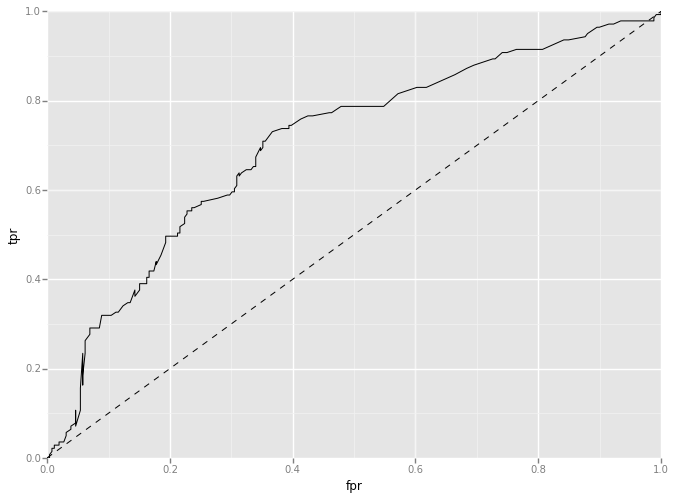

<ggplot: (279254949)>

In [60]:
from sklearn import metrics
from math import sqrt 
from ggplot import *
count1 = 0
count0 = 0
count = 0
sum1 = 0.0
per = result.predict(dfmovietest[['act_rate','dir_rate' , 'pro_rate' ,'rating']] )

fpr, tpr, pr = metrics.roc_curve(dfmovietest['blockbuster'], per)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')
#print fpr
#print tpr
#print pr


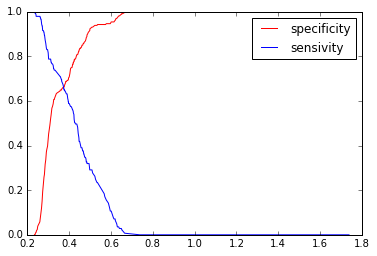

In [73]:
from numpy import *
import math
import matplotlib.pyplot as plt
#print 1-fpr
plt.plot(pr,1-fpr,'r',label= 'specificity')
plt.plot(pr,tpr,'b',label= 'sensivity')
plt.legend()

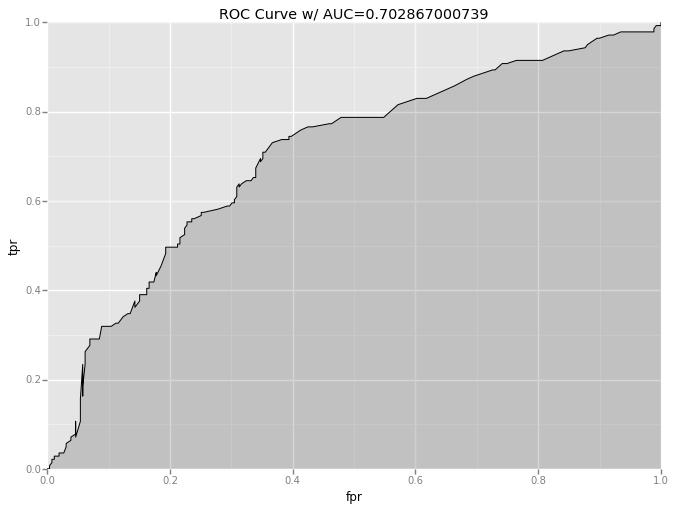

<ggplot: (279650709)>

In [61]:
auc = metrics.auc(fpr,tpr)
ggplot(df, aes(x='fpr', ymin=0, ymax='tpr')) +\
    geom_area(alpha=0.2) +\
    geom_line(aes(y='tpr')) +\
    ggtitle("ROC Curve w/ AUC=%s" % str(auc))

In [84]:
total1 =0
right1 = 0
total0 = 0
right0 = 0
wrong1 = 0
wrong0 = 0
for u,i in zip(pr,dfmovietest['blockbuster']):
    if i == 1:
        total1 += 1
        if u >= 0.40:
            right1 +=1
    elif i == 0:
        total0 += 1
        if u < 0.40:
            right0 +=1
        

print total1
print right1
print total0
print right0

print "sensitivity \t ",float(right1)/total1
print "specifcity \t ",float(right0)/total0

51
29
91
47
sensitivity 	  0.56862745098
specifcity 	  0.516483516484


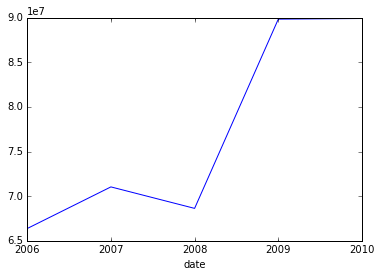

In [90]:
import datetime
import calendar
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics as metrics
from sklearn.metrics import pairwise_distances

times = pd.to_datetime(dfmovie.date)
data=dfmovie.groupby([times]).revenue.mean().resample('A',how='mean')
data['2006-01-01' : '2011-12-12'].plot()

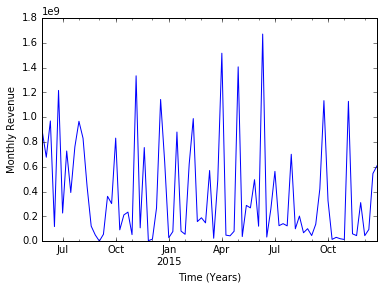

In [547]:
import datetime
import calendar
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics as metrics
from sklearn.metrics import pairwise_distances

times = pd.to_datetime(dfmoviefir.date)
data=dfmoviefir.groupby([times]).revenue.sum().resample('w',how='sum')
data['2014-06-01' : '2016-01-01'].plot()
plt.ylabel('Monthly Revenue')
plt.xlabel('Time (Years)')


In [87]:
movielist = []
import datetime
for i in range(len(dfmovie)):
    try:
        datetime.datetime.strptime(dfmovie['date'][i], '%m/%d/%y')
    except:
        dfmovie['date'][i] = 0


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [88]:
dfmovie = dfmovie[dfmovie.date != 0]
len(dfmovie)

3592

In [472]:
import pandas as pd
import os
datadir = 'data/'
movie_info = []
with open(os.path.join(datadir, 'movie_info3_2.csv'), "r") as h:
    for u in h:
        next_movie = []
        director_list = []
        
        movie_stuff = u.split(',')
        for i in range(0,len(movie_stuff)):
            if i < 10:
                next_movie.append(movie_stuff[i])
            else:
                name = movie_stuff[i].replace('[','').replace(']','')
                director_list.append(name)
        next_movie.append(director_list)
        if float(next_movie[8]) > 0  :
            movie_info.append(next_movie)
        
print len(movie_info)
dfmoviefir = pd.DataFrame(movie_info, columns = ['imdbid','name','year','date','rating','outof','budget','revenue','first_week','production','director'])
dfmoviefir

5773


,imdbid,name,year,date,rating,outof,budget,revenue,first_week,production,director
0,tt0170016,How the Grinch Stole Christmas,2000,11/17/00,6,139172,123000000,345141403,55082330,Universal Pictures,"['Ron Howard', , \r\n]"
1,tt0207201,What Women Want,2000,12/15/00,6.4,156277,70000000,374111707,33614543,Paramount Pictures,"['Nancy Meyers', , \r\n]"
2,tt0212338,Meet the Parents,2000,10/6/00,7,256121,55000000,330444045,28623300,Universal Pictures,"['Jay Roach', , \r\n]"
3,tt0175142,Scary Movie,2000,7/7/00,6.2,183807,19000000,278019771,42346669,Dimension Films,"['Keenen Ivory Wayans', , \r\n]"
4,tt0130623,Dinosaur,2000,5/19/00,6.4,37520,127500000,354248063,38854851,Walt Disney Pictures,"['Eric Leighton', 'Ralph Zondag', \r\n]"
5,tt0195685,Erin Brockovich,2000,3/17/00,7.3,132320,52000000,256271286,28138465,Universal Pictures,"['Steven Soderbergh', , \r\n]"
6,tt0181865,Traffic,2000,1/5/01,7.6,168551,48000000,207515725,184725,Bedford Falls Company,"[ The, 'Steven Soderbergh', \r\n]"
7,tt0208003,Big Mommas House,2000,6/2/00,5.1,65558,30000000,173959438,25661041,Twentieth Century Fox Film Corporation,"['Raja Gosnell', , \r\n]"
8,tt0187393,The Patriot,2000,6/28/00,7.1,203970,110000000,215294342,22413710,Columbia Pictures Corporation,"['Roland Emmerich', , \r\n]"
9,tt0120630,Chicken Run,2000,6/23/00,7,137419,42000000,224834564,17506162,DreamWorks Animation,"['Peter Lord', 'Nick Park', \r\n]"


In [125]:
top = dfmovie.head(100)

In [300]:
import pandas as pd
%matplotlib inline
import statsmodels.api as sm
import matplotlib.pyplot as plt
   
# giving the columns for training data set.
train_cols = newdf
logit = sm.Logit(dfmovie['blockbuster'], train_cols)
result = logit.fit()
print (result.summary())

         Current function value: 0.534612
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            blockbuster   No. Observations:                 3588
Model:                          Logit   Df Residuals:                     3584
Method:                           MLE   Df Model:                            3
Date:                Thu, 28 Apr 2016   Pseudo R-squ.:                 0.02058
Time:                        22:15:30   Log-Likelihood:                -1918.2
converged:                      False   LL-Null:                       -1958.5
                                        LLR p-value:                 2.266e-17
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
actor_rate_0         -0.5387        nan        nan        nan           nan       nan
actor_rate_1         -0.0997        nan     

//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
